In [1]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from pykalman import KalmanFilter
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler ,StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import entropy
from scipy.fft import rfft, rfftfreq
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [2]:
# ================================
# DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_Thermostat.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (32774, 6)

DATASET OVERVIEW
        date     time  current_temperature  thermostat_status  label  \
0  25-Apr-19  8:59:02            30.577325                  1      1   
1  25-Apr-19  8:59:06            29.187912                  1      1   
2  25-Apr-19  8:59:06            30.208893                  1      1   
3  25-Apr-19  8:59:06            27.731392                  1      1   
4  25-Apr-19  8:59:06            26.211462                  1      1   
5  25-Apr-19  8:59:07            30.496262                  1      1   
6  25-Apr-19  8:59:08            32.575755                  1      1   
7  25-Apr-19  8:59:08            28.928770                  1      1   
8  25-Apr-19  8:59:11            29.012420                  1      1   
9  25-Apr-19  8:59:11            30.013785                  1      1   

        type  
0  injection  
1  injection  
2  injection  
3  injection  
4  injection  
5  injection  
6  injection  
7  injection  


DATA EXPLORATION
Data Types:
date                    object
time                    object
current_temperature    float64
thermostat_status        int64
label                    int64
type                    object
dtype: object

Unique current temperature: [30.57732541 29.18791215 30.20889259 ... 26.01162765 30.09367188
 29.85261281]
Unique thermostat status: [1 0]
Attack type distribution:
type
normal        15000
injection      5000
backdoor       5000
password       5000
ransomware     2264
xss             449
scanning         61
Name: count, dtype: int64


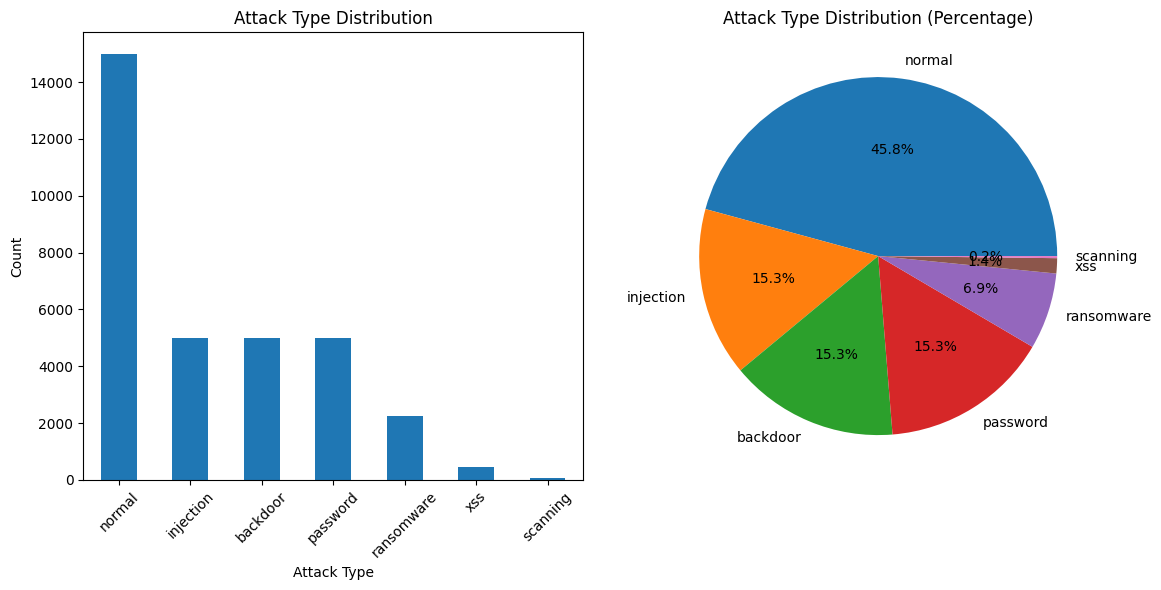

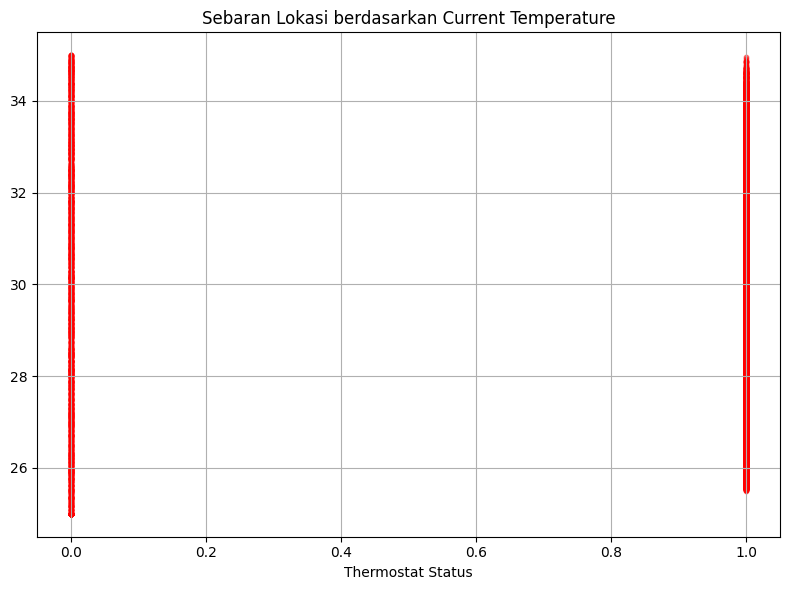

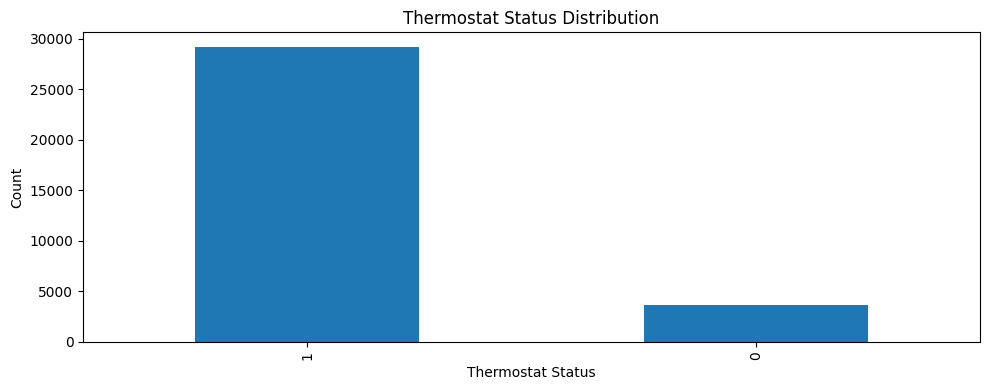

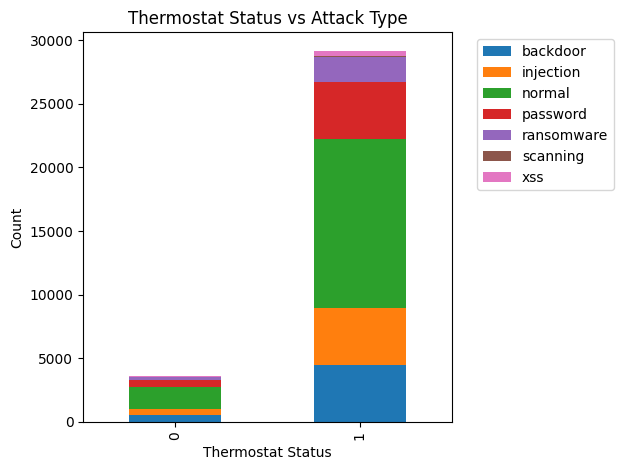

In [3]:
# ================================
# DATA EXPLORATION
# ================================

print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Check data types
print("Data Types:")
print(df.dtypes)

# Check unique values in categorical columns
print(f"\nUnique current temperature: {df['current_temperature'].unique()}")
print(f"Unique thermostat status: {df['thermostat_status'].unique()}")
print(f"Attack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

# Visualize attack type distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['thermostat_status'], df['current_temperature'],
            c='red', alpha=0.5, s=10)
plt.title('Sebaran Lokasi berdasarkan Current Temperature')
plt.xlabel('Thermostat Status')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'location_temperature_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

# Thermostat Status distribution
plt.figure(figsize=(10, 4))
df['thermostat_status'].value_counts().plot(kind='bar')
plt.title('Thermostat Status Distribution')
plt.xlabel('Thermostat Status')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'thermostat_status_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['thermostat_status'], df['type']).plot(kind='bar', stacked=True)
plt.title('Thermostat Status vs Attack Type')
plt.xlabel('Thermostat Status')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'thermostat_status_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Implementasi Kalman Filter
def apply_kalman_filter(signal_data):
    if hasattr(signal_data, 'values'):
        signal_array = signal_data.values
    else:
        signal_array = np.array(signal_data)
    observations = signal_array.reshape(-1, 1)
    kf = KalmanFilter(
        transition_matrices=np.array([[1, 1], [0, 1]]),
        observation_matrices=np.array([[1, 0]]),
        initial_state_mean=np.array([signal_array[0], 0]),
        initial_state_covariance=np.eye(2),
        observation_covariance=np.array([[1.0]]),
        transition_covariance=np.array([[0.1, 0], [0, 0.1]]),
        n_dim_state=2
    )
    kf_fitted = kf.em(observations, n_iter=10)
    state_means, _ = kf_fitted.smooth(observations)
    return state_means[:, 0]

In [5]:
df_filtered = df.copy()
df_filtered['current_temperature'] = apply_kalman_filter(df['current_temperature'])

In [6]:
# ================================
# FEATURE ENGINEERING
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

df_processed = df_filtered.copy()

# Gabung datetime dan ekstrak komponen
df_processed['datetime'] = pd.to_datetime(df_processed['date'].str.strip() + ' ' + df_processed['time'].str.strip(),
                                format='%d-%b-%y %H:%M:%S', errors='coerce')
df_processed = df_processed.sort_values('datetime')
df_processed['hour']        = df_processed['datetime'].dt.hour
df_processed['minute']      = df_processed['datetime'].dt.minute
df_processed['second']      = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend']  = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['hour_sin']    = np.sin(2*np.pi*df_processed['hour']/24)
df_processed['hour_cos']    = np.cos(2*np.pi*df_processed['hour']/24)
df_processed['min_sin']     = np.sin(2*np.pi*df_processed['minute']/60)
df_processed['min_cos']     = np.cos(2*np.pi*df_processed['minute']/60)

# Time diff
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds().fillna(0)

# Temperature Dynamics Features
# --------------------------------
win = 10  # Rolling window size

# Basic rolling stats
df_processed['temp_roll_mean'] = df_processed['current_temperature'].rolling(window=win, min_periods=1).mean()
df_processed['temp_roll_std'] = df_processed['current_temperature'].rolling(window=win, min_periods=1).std().fillna(0)
df_processed['temp_roll_range'] = (df_processed['current_temperature'].rolling(window=win, min_periods=1).max() - 
                                  df_processed['current_temperature'].rolling(window=win, min_periods=1).min())

# Rate of change
df_processed['temp_diff'] = df_processed['current_temperature'].diff().fillna(0)
df_processed['temp_velocity'] = df_processed['temp_diff'] / df_processed['time_diff'].replace(0, 1e-6)
df_processed['temp_acceleration'] = df_processed['temp_velocity'].diff().fillna(0) / df_processed['time_diff'].replace(0, 1e-6)

# Stability metrics
df_processed['temp_zscore'] = (df_processed['current_temperature'] - df_processed['temp_roll_mean']) / df_processed['temp_roll_std'].replace(0, 1e-6)
df_processed['is_temp_anomaly'] = (np.abs(df_processed['temp_zscore']) > 3).astype(int)

# Thermostat Behavior Features
# -------------------------------
# State changes
df_processed['thermostat_change'] = df_processed['thermostat_status'].diff().abs().fillna(0)
# Buat kelompok perubahan status
group_ids = (df_processed['thermostat_status'] != df_processed['thermostat_status'].shift(1)).cumsum()

# Hitung durasi total dari setiap status dalam satu grup
df_processed['thermostat_state_duration'] = group_ids.map(
    df_processed.groupby(group_ids)['time_diff'].cumsum()
)
# State statistics
df_processed['on_state_percentage'] = (df_processed['thermostat_status']
                                       .rolling(window=win, min_periods=1)
                                       .mean())

# Advanced Signal Processing Features
# --------------------------------------
from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy

def dominant_freq(arr, sr=1.0):
    if len(arr) < 3:  # Minimum samples for FFT
        return 0.0
    yf = np.abs(rfft(arr - np.mean(arr)))  # Remove DC component
    xf = rfftfreq(len(arr), d=1/sr)
    if len(yf) < 2:  # Handle small arrays
        return 0.0
    idx = np.argmax(yf[1:]) + 1  # Skip DC component
    return xf[idx]

def signal_entropy(arr):
    if len(arr) < 2:
        return 0.0
    hist, _ = np.histogram(arr, bins=10, density=True)
    hist = hist[hist > 0]
    return entropy(hist)

# Apply advanced features
df_processed['temp_dom_freq'] = (df_processed['current_temperature']
                                 .rolling(window=win, min_periods=3)
                                 .apply(lambda x: dominant_freq(x.values, sr=1), raw=False)
                                 .fillna(0))

df_processed['temp_entropy'] = (df_processed['current_temperature']
                                .rolling(window=win, min_periods=2)
                                .apply(signal_entropy, raw=False)
                                .fillna(0))

# Interaction Features
# -----------------------
df_processed['temp_state_interaction'] = df_processed['current_temperature'] * df_processed['thermostat_status']
df_processed['velocity_state_interaction'] = df_processed['temp_velocity'] * df_processed['thermostat_status']

# Cleanup
new_features = [col for col in df_processed.columns if col not in df_filtered.columns]
print(f"Added {len(new_features)} new features: {new_features}")



FEATURE ENGINEERING
Added 26 new features: ['datetime', 'hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'time_diff', 'temp_roll_mean', 'temp_roll_std', 'temp_roll_range', 'temp_diff', 'temp_velocity', 'temp_acceleration', 'temp_zscore', 'is_temp_anomaly', 'thermostat_change', 'thermostat_state_duration', 'on_state_percentage', 'temp_dom_freq', 'temp_entropy', 'temp_state_interaction', 'velocity_state_interaction']


In [7]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32774 entries, 14857 to 5799
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        32774 non-null  object        
 1   time                        32774 non-null  object        
 2   current_temperature         32774 non-null  float64       
 3   thermostat_status           32774 non-null  int64         
 4   label                       32774 non-null  int64         
 5   type                        32774 non-null  object        
 6   datetime                    32774 non-null  datetime64[ns]
 7   hour                        32774 non-null  int32         
 8   minute                      32774 non-null  int32         
 9   second                      32774 non-null  int32         
 10  day_of_week                 32774 non-null  int32         
 11  is_weekend                  32774 non-null  int32       

In [8]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")


MISSING VALUES ANALYSIS
Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values found in the dataset!


In [9]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32774 entries, 14857 to 5799
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        32774 non-null  object        
 1   time                        32774 non-null  object        
 2   current_temperature         32774 non-null  float64       
 3   thermostat_status           32774 non-null  int64         
 4   label                       32774 non-null  int64         
 5   type                        32774 non-null  object        
 6   datetime                    32774 non-null  datetime64[ns]
 7   hour                        32774 non-null  int32         
 8   minute                      32774 non-null  int32         
 9   second                      32774 non-null  int32         
 10  day_of_week                 32774 non-null  int32         
 11  is_weekend                  32774 non-null  int32       

In [10]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Prepare features and target
X = df_processed.copy()
X.drop(['date','time','datetime','type','label','is_temp_anomaly'], axis=1, inplace=True)
y = df_processed['type'].copy()


# Handle any remaining missing values with SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"Features shape after imputation: {X_imputed.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

print("Data scaling completed!")
print(f"Scaled features shape: {X_scaled.shape}")

# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
label_encoder_target = LabelEncoder()
y_encoded = label_encoder_target.fit_transform(y)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(label_encoder_target, f)

print(f"Target classes: {label_encoder_target.classes_}")
print(f"Target shape: {y_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Features shape after imputation: (32774, 26)
Data scaling completed!
Scaled features shape: (32774, 26)
Imputer saved to artifacts/imputer.pkl
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'injection' 'normal' 'password' 'ransomware' 'scanning' 'xss']
Target shape: (32774,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [11]:
y_cat = to_categorical(y_encoded)

In [12]:
print(X_scaled.info())
print('\n',y_encoded.shape)
print('\n',y_encoded[:10])
print('\n',y_cat.shape)
print('\n',y_cat[:10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32774 entries, 0 to 32773
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   current_temperature         32774 non-null  float64
 1   thermostat_status           32774 non-null  float64
 2   hour                        32774 non-null  float64
 3   minute                      32774 non-null  float64
 4   second                      32774 non-null  float64
 5   day_of_week                 32774 non-null  float64
 6   is_weekend                  32774 non-null  float64
 7   hour_sin                    32774 non-null  float64
 8   hour_cos                    32774 non-null  float64
 9   min_sin                     32774 non-null  float64
 10  min_cos                     32774 non-null  float64
 11  time_diff                   32774 non-null  float64
 12  temp_roll_mean              32774 non-null  float64
 13  temp_roll_std               327

In [13]:
# ================================
# SELEKSI FITUR GA
# ================================

# Split data validasi untuk fitness eval
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y_encoded)

# --- Parameters GA ---
POP_SIZE = 20
N_GENERATIONS = 10
MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 3
FEATURE_COUNT = X.shape[1]

# --- Fungsi buat model LSTM ---
def create_lstm_model(input_shape, n_classes):
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# --- Fungsi fitness ---
def fitness(individual):
    if sum(individual) == 0:
        return 0.0,

    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    X_train_sub = X_train.iloc[:, selected_features].values
    X_val_sub = X_val.iloc[:, selected_features].values

    # reshape to 3D
    X_train_sub = X_train_sub.reshape((X_train_sub.shape[0], 1, X_train_sub.shape[1]))
    X_val_sub = X_val_sub.reshape((X_val_sub.shape[0], 1, X_val_sub.shape[1]))

    model = create_lstm_model(input_shape=(1, len(selected_features)), n_classes=y_cat.shape[1])
    model.fit(X_train_sub, y_train, epochs=3, batch_size=64, verbose=0)

    y_pred = np.argmax(model.predict(X_val_sub, verbose=0), axis=1)
    y_true = np.argmax(y_val, axis=1)
    acc = accuracy_score(y_true, y_pred)

    return acc,

# --- GA tools ---
def init_population():
    return [np.random.randint(0, 2, FEATURE_COUNT).tolist() for _ in range(POP_SIZE)]

def tournament_selection(pop, fitnesses):
    selected = random.sample(list(zip(pop, fitnesses)), TOURNAMENT_SIZE)
    selected = sorted(selected, key=lambda x: x[1][0], reverse=True)  # ambil akurasi dari tuple
    return selected[0][0]

def crossover(parent1, parent2):
    point = random.randint(1, FEATURE_COUNT - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual):
    for i in range(FEATURE_COUNT):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]

# --- Main GA Loop ---
population = init_population()
fitnesses = [fitness(ind) for ind in population]

for gen in range(N_GENERATIONS):
    print(f'\nGeneration {gen + 1}/{N_GENERATIONS}')
    
    # Ekstrak nilai fitness dari tuple
    accs = [fit[0] for fit in fitnesses]
    print(f' Best fitness: {max(accs):.4f} | Avg fitness: {np.mean(accs):.4f}')

    new_population = []
    while len(new_population) < POP_SIZE:
        parent1 = tournament_selection(population, fitnesses)
        parent2 = tournament_selection(population, fitnesses)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1)
        mutate(child2)
        new_population.extend([child1, child2])

    # evaluasi populasi baru
    population = new_population[:POP_SIZE]
    fitnesses = [fitness(ind) for ind in population]

# --- Evaluasi akhir ---
accs = [fit[0] for fit in fitnesses]
best_idx = np.argmax(accs)
best_individual = population[best_idx]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

print("\n--- Hasil Seleksi Fitur GA ---")
print("Selected Features Indexes:", selected_features)
print("Best Fitness (Accuracy): {:.4f}".format(accs[best_idx]))


Generation 1/10
 Best fitness: 0.9664 | Avg fitness: 0.7957

Generation 2/10
 Best fitness: 0.9696 | Avg fitness: 0.9204

Generation 3/10
 Best fitness: 0.9735 | Avg fitness: 0.9408

Generation 4/10
 Best fitness: 0.9706 | Avg fitness: 0.9543

Generation 5/10
 Best fitness: 0.9733 | Avg fitness: 0.9519

Generation 6/10
 Best fitness: 0.9718 | Avg fitness: 0.9504

Generation 7/10
 Best fitness: 0.9722 | Avg fitness: 0.9646

Generation 8/10
 Best fitness: 0.9730 | Avg fitness: 0.9616

Generation 9/10
 Best fitness: 0.9713 | Avg fitness: 0.9652

Generation 10/10
 Best fitness: 0.9721 | Avg fitness: 0.9198

--- Hasil Seleksi Fitur GA ---
Selected Features Indexes: [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 20, 21, 22, 24]
Best Fitness (Accuracy): 0.9719


In [14]:
selected_feature_names = [X_scaled.columns[i] for i in selected_features]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['hour', 'minute', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'time_diff', 'temp_roll_mean', 'temp_roll_range', 'temp_velocity', 'temp_acceleration', 'thermostat_state_duration', 'on_state_percentage', 'temp_dom_freq', 'temp_state_interaction']


In [15]:
X_selected = X_scaled.iloc[:, selected_features]
print(X_selected.shape)
print(X_selected.info())
print(X_selected.head())

(32774, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32774 entries, 0 to 32773
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hour                       32774 non-null  float64
 1   minute                     32774 non-null  float64
 2   day_of_week                32774 non-null  float64
 3   is_weekend                 32774 non-null  float64
 4   hour_sin                   32774 non-null  float64
 5   hour_cos                   32774 non-null  float64
 6   min_sin                    32774 non-null  float64
 7   min_cos                    32774 non-null  float64
 8   time_diff                  32774 non-null  float64
 9   temp_roll_mean             32774 non-null  float64
 10  temp_roll_range            32774 non-null  float64
 11  temp_velocity              32774 non-null  float64
 12  temp_acceleration          32774 non-null  float64
 13  thermostat_state_duration  32774 n


CORRELATION ANALYSIS


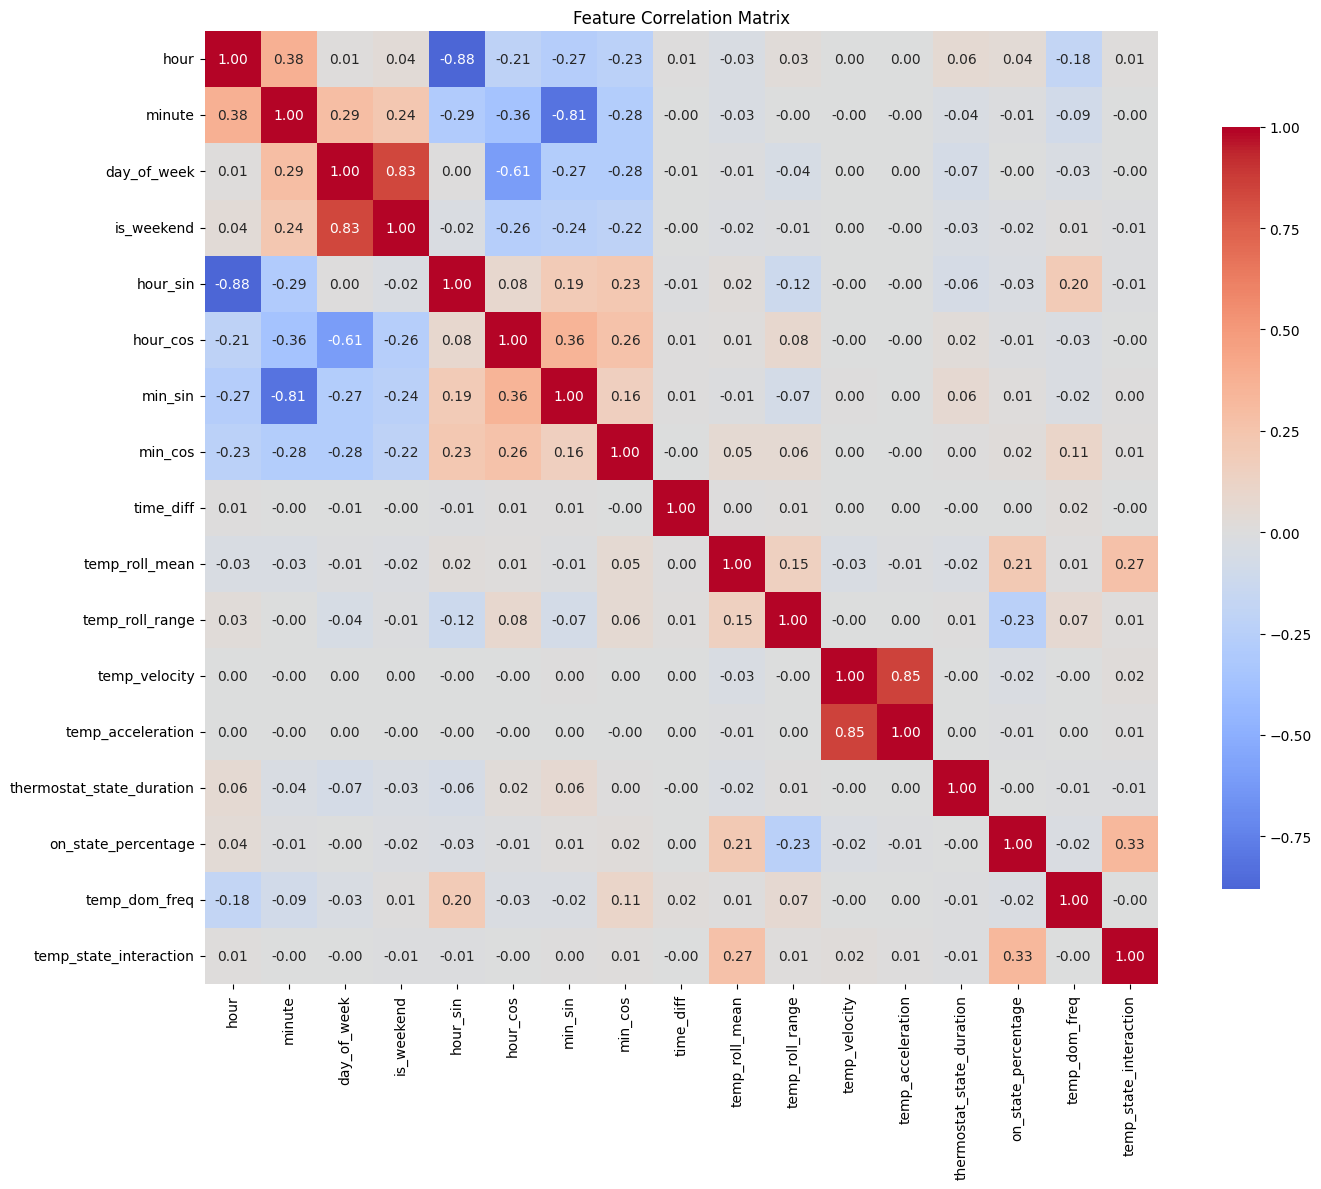

In [16]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_selected.corr()

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

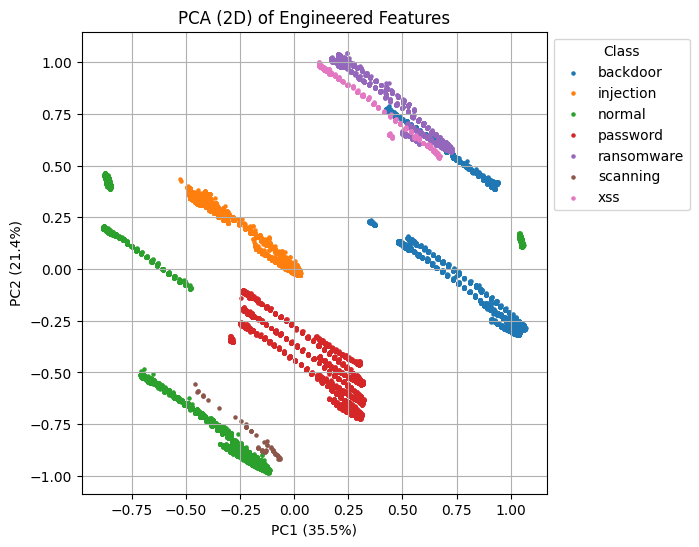

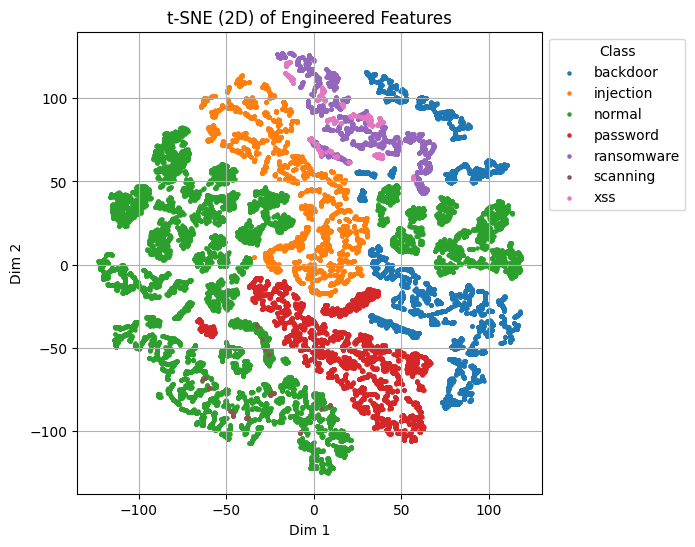

In [17]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_selected)

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4) t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_selected)

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [18]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_selected)

# 2) Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y.astype(str)
})

# 3) Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# 4) Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_selected)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [19]:
with open(os.path.join(artifacts_dir, 'data_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_selected, y_encoded), f)
    
# Simpan ke file CSV
# Pastikan X_scaled adalah array 2D dan y_encoded 1D (atau sesuai bentuk)
df = pd.DataFrame(X_selected)
df['label'] = np.array(y_encoded)

csv_path = os.path.join(artifacts_dir, 'data_preprocessing.csv')
df.to_csv(csv_path, index=False)